In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.datasets import fetch_mldata, fetch_lfw_people
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import time

### Image Classification with Dimensionality Reduction
### (a) i. Load two datasets: MNIST (number recognition), LFW (face recognition).

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

mnist = fetch_mldata('MNIST original')
lfw = fetch_lfw_people()

### (a) ii. Split each dataset into a 75/25 train/test split.

In [3]:
mnist['data'].shape

(70000, 784)

In [4]:
mnist['target'].shape

(70000,)

In [5]:
# sample part of the dataset for speed
mnist_small_idx = np.random.randint(0,70000,size=2000)

In [6]:
mnist_X_train_original, mnist_X_test_original, mnist_Y_train, mnist_Y_test = train_test_split(mnist['data'][mnist_small_idx], 
                                                                                              mnist['target'][mnist_small_idx], 
                                                                                              random_state=123, 
                                                                                              shuffle=False)

lfw_X_train_original, lfw_X_test_original, lfw_Y_train, lfw_Y_test = train_test_split(lfw.data, lfw.target, 
                                                                                      random_state=456, 
                                                                                      shuffle=False)

In [7]:
# helper functions for PCA
def plot_explained_variance(n_feature, X_train):
    pca = PCA(n_feature)
    pca_full = pca.fit(X_train)
    plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
    plt.xlabel("number of principal components")
    plt.ylabel("cumulative explained variance")
    plt.grid(color='grey',linestyle='-',alpha=0.2)
    plt.show()
    
def preprocess_pca(X_train, X_test, r=None):
    pca = PCA(n_components=dim, random_state=r)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca    

### (b) Feature sizes: For each dataset, train and evaluate two clssification algorithms (e.g., SVM, Naive Bayes, Decision Tree, KNN) with at least 25 different feature dimension sizes. To achieve the different feature dimension sizes, you will need to vary the number of principal components you keep using the unsupervised dimensionality reduction algorithm PCA. (Code)
### (c) Report the predictive performance of each classifier on each dataset as a function of the feature dimension size (i.e., number of principal components). As a result, your write-up should include four plots to show results for both classifications algorithms on both datasets. (Write-up)

### (b) MNIST

In [8]:
sc = StandardScaler()
mnist_X_train = sc.fit_transform(mnist_X_train_original)
mnist_X_test = sc.transform(mnist_X_test_original)

/Users/edithzeng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


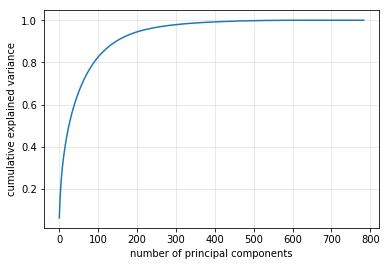

In [12]:
plot_explained_variance(784, mnist_X_train)

The explained variance indicates that over 90% of the original data's variability can be explained with about 200 principal components (the elbow in the curve). Using additional principal components gives us diminishing returns as the growth in variance decreases. Judging by the graph the hypothesis is that a classifier can achieve good performance with approximately 200 or less principal components. To test this hypothsis, I will vary the number of principal components and evaluate the linear SVM classifier and a KNN classifer's performances on the dimensionality-reduced MNIST dataset.

In [10]:
C_list = [0.1, 1.0, 10.0]
K_list = [5, 10, 20, 40, 60, 120]
feature_dim_list = [2, 5, 10, 20, 30] + [i*2 for i in range(20, 120)]

#### MNIST - SVM

In [13]:
def svm(X_train, X_test, Y_train, Y_test):
    
    cv_scores = []
    for n in C_list:
        cv_model = LinearSVC(loss='hinge', C=n, random_state=7)
        kf = KFold(n_splits=10, shuffle=False, random_state=1)
        score = np.mean(cross_val_score(cv_model, X_train, Y_train, cv=kf))
        cv_scores.append(score)
    cv_scores = np.asarray(cv_scores)
    
    best_c = C_list[cv_scores.argmax()]
    model = LinearSVC(loss='hinge', C=best_c, random_state=7)
    model.fit(X_train, Y_train)

    return model.score(X_test, Y_test)

In [35]:
mnist_svm_original = svm(mnist_X_train, mnist_X_test, mnist_Y_train, mnist_Y_test)
print("SVM accuracy score before PCA: {}".format(mnist_svm_original))

SVM accuracy score before PCA: 0.816


Optimal number of principal components for linear SVM on MNIST: 56
accuracy: 0.878
Average runtime: 256.8464300042107


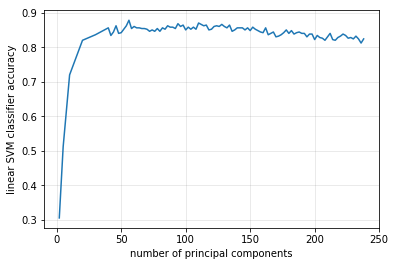

In [20]:
mnist_svm_scores = []
t1_list = []
for dim in feature_dim_list:
    X_train, X_test = preprocess_pca(mnist_X_train, mnist_X_test, r=2)
    t1 = time.time()
    mnist_svm_scores.append(svm(X_train, X_test, mnist_Y_train, mnist_Y_test))
    t1_list.append(time.time()-t1)

mnist_svm_scores = np.asarray(mnist_svm_scores)

plt.grid(color='grey',linestyle='-',alpha=0.2)
plt.plot(feature_dim_list, mnist_svm_scores)

plt.xlabel("number of principal components")
plt.ylabel("linear SVM classifier accuracy")
print("Optimal number of principal components for linear SVM on MNIST:", feature_dim_list[mnist_svm_scores.argmax()])
print("accuracy: {}\nAverage runtime: {}".format(max(mnist_svm_scores), np.mean(t1_list)))

#### (c) MNIST - SVM - write up

The linear SVM classifier achieved a test accuracy of 0.816 on the original dataset ($2000\times784$) and took about 162 seconds to run. The plot shows that as we increase the number of principal components from 2, the linear SVM classifier's performance on the test set continues to improve. After PCA dimensionality reduction, the classifier achieves an accuracy of 0.878 with only 56 principal components. After this point, adding more principal components did not yield a significant increase in accuracy.

#### MNIST - KNN

In [21]:
def knn(X_train, X_test, Y_train, Y_test):
    
    # cross validate to select optimal K
    cv_scores = []
    for k in K_list:
        cv_model = KNeighborsClassifier(n_neighbors=k)
        kf = KFold(n_splits=10, shuffle=False, random_state=1)
        score = np.mean(cross_val_score(cv_model, X_train, Y_train, cv=kf))
        cv_scores.append(score)
    cv_scores = np.asarray(cv_scores)
    
    # test accuracy
    best_k = K_list[cv_scores.argmax()]
    model = KNeighborsClassifier(n_neighbors=best_k)
    model.fit(X_train, Y_train)

    return model.score(X_test, Y_test)

In [23]:
t2 = time.time()
knn_mnist_original_score = knn(mnist_X_train, mnist_X_test, mnist_Y_train, mnist_Y_test)
dt2 = time.time() - t2
print("KNN accuracy score before PCA:{}\nruntime: {}".format(knn_mnist_original_score, dt2))

KNN accuracy score before PCA:0.866
runtime: 33.289095878601074


Optimal number of principal components for KNN on MNIST: 44
accuracy: 0.892
Average runtime: 3.9989661625453405


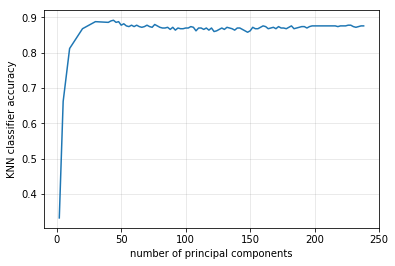

In [24]:
mnist_knn_scores = []
t3_list = []
for dim in feature_dim_list:
    X_train, X_test = preprocess_pca(mnist_X_train, mnist_X_test, r=2)
    t3 = time.time()
    mnist_knn_scores.append(knn(X_train, X_test, mnist_Y_train, mnist_Y_test))
    t3_list.append(time.time()-t3)

mnist_knn_scores = np.asarray(mnist_knn_scores)

plt.grid(color='grey',linestyle='-',alpha=0.2)
plt.plot(feature_dim_list, mnist_knn_scores)

plt.xlabel("number of principal components")
plt.ylabel("KNN classifier accuracy")
print("Optimal number of principal components for KNN on MNIST:", feature_dim_list[mnist_knn_scores.argmax()])
print("accuracy: {}\nAverage runtime: {}".format(max(mnist_knn_scores), np.mean(t3_list)))

#### (c) MNIST - KNN - write up

The KNN classifier has a better overall performance compared to the linear SVM classifier. It achieved an accuracy of 0.866 in 33 seconds on the original dataset. After reducing dimensionality from 784 to 44, the optimal performance has an accuracy of 0.89. The process is also significantly faster; the average runtime after each PCA projection is about 4 seconds. Similar to the linear SVM classifier, the accuracy curve becomes flat after reaching the optimal number of principal components.

Results from KNN and SVM have comfirmed the hypothesis that using under 200 principal components is sufficient for the  classification task on this (reduced) MNIST dataset.

### (b) LFW

In [25]:
lfw.data.shape

(13233, 2914)

In [26]:
sc2 = StandardScaler()
lfw_X_train = sc2.fit_transform(lfw_X_train_original)
lfw_X_test = sc2.transform(lfw_X_test_original)

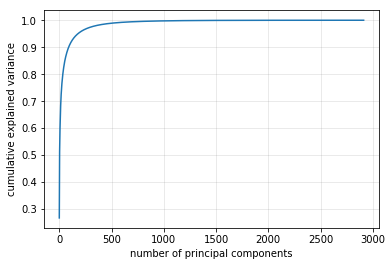

In [27]:
plot_explained_variance(2914, lfw_X_train)

The LFW dataset has a higher dimension (2914) than the MNIST dataset (784). The plot suggests that using approximately 300 or less principal components suffices.

In [28]:
feature_dim_list_lfw = [5, 10, 20, 70, 100, 140, 200, 250]

#### LFW - Naive Bayes 

In [29]:
def nb(X_train, X_test, Y_train, Y_test):
    model = GaussianNB()
    model.fit(X_train, Y_train)
    return model.score(X_test, Y_test)

In [30]:
t4 = time.time()
nb_lfw_original_score = nb(lfw_X_train, lfw_X_test, lfw_Y_train, lfw_Y_test)
dt4 = time.time() - t4
print("Naive Bayes accuracy on original LFW dataset: {}\nruntime: {}".format(nb_lfw_original_score, dt4))

Naive Bayes accuracy on original LFW dataset: 0.051979449984889695
runtime: 578.1048769950867


Optimal number of principal components for Naive Bayesian classifier on LFW: 100
Accuracy: 0.12692656391659113
Average runtime: 20.827672004699707


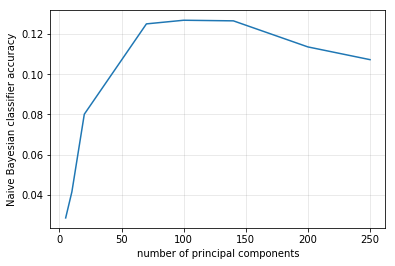

In [36]:
lfw_nb_scores = []
lfw_nb_t = []

for dim in feature_dim_list_lfw:
    X_train, X_test = preprocess_pca(lfw_X_train, lfw_X_test)
    lfw_t0 = time.time()
    lfw_nb_scores.append(nb(X_train, X_test, lfw_Y_train, lfw_Y_test))
    lfw_nb_t.append(time.time()-lfw_t0)
    
lfw_nb_scores = np.asarray(lfw_nb_scores)

plt.grid(color='grey',linestyle='-',alpha=0.2)
plt.plot(feature_dim_list_lfw, lfw_nb_scores)

plt.xlabel("number of principal components")
plt.ylabel("Naive Bayesian classifier accuracy")
print("Optimal number of principal components for Naive Bayesian classifier on LFW:", feature_dim_list_lfw[lfw_nb_scores.argmax()])
print("Accuracy: {}\nAverage runtime: {}".format(max(lfw_nb_scores), np.mean(lfw_nb_t)))

#### (c) LFW - Naive Bayes - Write up 

Accuracy of the naive Bayes classifier on the original dataset ($13233\times2914$) achieved an accuracy of 0.05 in 578 seconds. By reducing dimensionality to 100 principal components, the accuracy increased to 0.12 and the average run time is much shorter at 23 seconds. Judging by the plot, the classifier's performance deteriorates after using 100 principal components.

#### LFW - Random Forest

In [32]:
def rf(X_train, X_test, Y_train, Y_test, fold=10):
    model = RandomForestClassifier(n_estimators=30, max_features='sqrt', oob_score=True, warm_start=True)
    model.fit(X_train, Y_train)
    model.oob_score_
    return model.score(X_test, Y_test)

In [33]:
rf_t0 = time.time()
lfw_rf_original_score = rf(lfw_X_train, lfw_X_test, lfw_Y_train, lfw_Y_test)
rf_dt = time.time() - rf_t0
print("Random forest on original LFW dataset\nAccuracy: {}\nRuntime: {}".format(lfw_rf_original_score, rf_dt))

Random forest on original LFW dataset
Accuracy: 0.06406769416742218
Runtime: 4296.494551181793


Optimal number of principal components for random forest classifier on LFW: 20
Accuracy: 0.061952251435479
 Average runtime: 1291.0738012492657


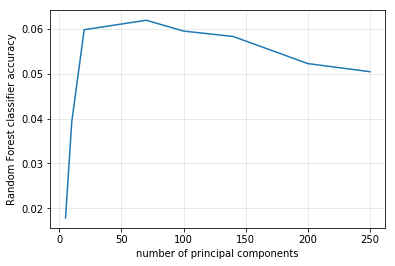

In [34]:
rft_list = []
lfw_rf_scores = []

for dim in feature_dim_list_lfw:
    X_train, X_test = preprocess_pca(lfw_X_train, lfw_X_test)
    rft = time.time()
    lfw_rf_scores.append(rf(X_train, X_test, lfw_Y_train, lfw_Y_test))
    rft_list.append(time.time()-rft)

lfw_rf_scores = np.asarray(lfw_rf_scores)

plt.grid(color='grey',linestyle='-',alpha=0.2)
plt.plot(feature_dim_list_lfw, lfw_rf_scores)

plt.xlabel("number of principal components")
plt.ylabel("Random Forest classifier accuracy")
print("Optimal number of principal components for random forest classifier on LFW:", feature_dim_list[lfw_rf_scores.argmax()])
print("Accuracy: {}\n Average runtime: {}".format(max(lfw_rf_scores),np.mean(rft_list)))

#### LFW - Random forest - write up

The random forest classifier combines multiple trees and achieved optimal performance with 20 principal components. Although there is no improvement in accuracy (0.064 on the original dataset and 0.062 on the PCA-transformed dataset with 20 principal components), this is likely due to the fact that I've only used 30 trees due to computational constraints. The random forest classifiers fit with both the original dataset and the PCA-reduced dataset took the longest to run among all the classifiers tested with significant memory consumption. Limiting maximal tree depth could potentially alleviate the issue.

### (d) Write a discussion analyzing the influence of applying PCA on the classiffication performance. For example, what feature dimension sizes were better/worse and why do you think so? What can you infer by observing the classiffcation performance across the different datasets and different classiffcation algorithms? Your discussion should consist of two to four paragraphs. (Write-up)

PCA performs dimension reduction by finding linear combinations of the original features and project them into a lower dimensional space. Each dataset and algorithm's combination requires a unique number of optimal principal compnoents (ranged from 20 to 100 for the LFW dataset). One common purpose of this dimension reduction preprocessing is to reduce variance and prevent overfitting. In a high dimensional setting, an observation's nearest neighbors may be actually very far away, and the algorithm is prone to overfittig. Preprocessing the MNIST and LFW datasets leads to an improvement in the KNN classifier's performance. 

A compressed dataset is also more efficient to train and evaluate. For all algorithms and datasets tested so far, the PCA-processed dataset had shorter average runtimes compared to the original dataset.

Dimension reduction techniques like PCA is also useful for visualizing high dimensional data by projecting them into a 2- or 3-dimensional space and plot them to see if they form any clusters. 